# Démonstration : fit d'un spectre de rubis avec Python

De nombreuses opérations peuvent être réalisées grâce aux fonctions natives de Python. Malgré cela on commence souvent par importer quelques *modules* qui vont apporter des fonctionnalités supplémentaires.
Ici, nous allons importer des grands classiques:
- `numpy` : algèbre linéaire et mathématiques
- `matplotlib` : tracé graphique
- `scipy` : calcul scientifique, ici la fonction `curve_fit` qui sert aux regression non linéaires

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Pour tracer des figures de bonne qualité avec matplotlib (format vectoriel) directement dans le notebook :
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')

On a ici procédé à 2 types d'import:
- le format `import module as alias` pour importer un module et toutes ses méthodes (fonctionnalités), que l'on pourra appeler en utilisant `alias.methode`.
- le format `from module import methode`qui permet de n'importer qu'une seule méthode (fonctionnalité), que l'on pourra appeler directement.

Notons que certains modules ont un format de "packages", c'est à dire qu'ils contiennent des sous-modules : c'est le cas par exemple dans l'instruction `from scipy.optimize import curve_fit` où seule la fonction `curve_fit` issue du sous-module `optimize` de `scipy` est chargée.

## Chargement du fichier de données

On commence par charger le fichier de données obtenu par la mesure spectroscopique. Le fichier texte contient deux colonnes : les longueurs d'onde en nm, et les intensités (en unité arbitaire). On utilise la fonction [`loadtxt`](https://numpy.org/doc/stable/reference/generated/numpy.loadtxt.html) fournie par le module `numpy` :

In [16]:
# Read data from text file:
# les colonnes sont séparées par le caractère tab, codé par \t
data = np.loadtxt('Exemple_Rubis.asc', delimiter='\t')

# La première colonne correspond aux longueurs d'ondes :
x_data = data[:, 0]
# La seconde aux intensités :
y_data = data[:, 1]

# affichons un aperçu des tableaux obtenus:
print('x:', x_data)
print('y:', y_data)

x: [687.98301872 687.99579861 688.00905234 ... 701.10187015 701.11415896
 701.12693978]
y: [541. 514. 495. ... 626. 655. 635.]


## Tracé des données

Nous utilisons la bibliothèque `matplotlib` afin de visualiser les données. Nous ajoutons des étiquettes d'axes et une légende.

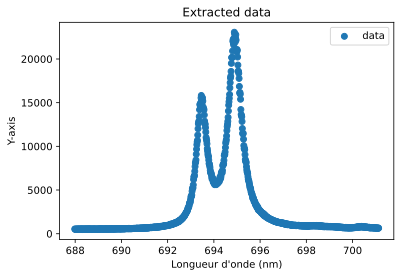

In [17]:
# on crée une figure :
plt.figure(1)

# on trace les données sous la forme d'un nuage de points avec plt.scatter:
plt.scatter(x_data, y_data, label='data')

# On ajoute des étiquettes d'axe
plt.xlabel("Longueur d'onde (nm)")
plt.ylabel('Y-axis')

# On ajoute une légende:
plt.legend()

# et un titre:
plt.title('Extracted data')

plt.show()

## Ajustement d'une fonction avec la fonction `curve_fit` de `scipy`

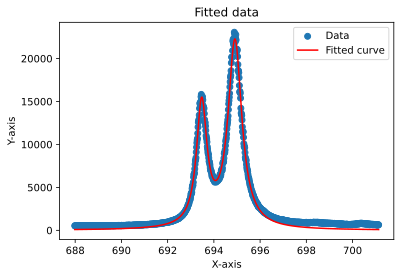

Optimized Parameters:
a1: 14229.033639066947
x01: 693.4731795298209
gamma1: -0.27079825887580616
a2: 21796.419450963596
x02: 694.9120022836939
gamma2: 0.359829369594248


In [18]:
# Define the double Lorentzian function
def double_lorentzian(x, a1, x01, gamma1, a2, x02, gamma2):
    return (a1 * gamma1**2) / ((x - x01)**2 + gamma1**2) + (a2 * gamma2**2) / ((x - x02)**2 + gamma2**2)


# Initial guesses for the parameters
initial_guesses = [1, 0, 1, 1, 1, 1]  # Adjust initial guesses as per your data

# Fit the data to the double Lorentzian function
popt, pcov = curve_fit(double_lorentzian, x_data, y_data, p0=initial_guesses)

# Plot the original data and the fitted curve
plt.figure(2)
plt.scatter(x_data, y_data, label='Data')
plt.plot(x_data, double_lorentzian(x_data, *popt), color='red', label='Fitted curve')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.title('Fitted data')
plt.show()

# Print the optimized parameters
print("Optimized Parameters:")
print("a1:", popt[0])
print("x01:", popt[1])
print("gamma1:", popt[2])
print("a2:", popt[3])
print("x02:", popt[4])
print("gamma2:", popt[5])


## Ajustement avec la bibliothèque `lmfit`

[[Model]]
    Model(double_lorentzian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 608
    # data points      = 1024
    # variables        = 6
    chi-square         = 1.8363e+08
    reduced chi-square = 180380.029
    Akaike info crit   = 12399.2712
    Bayesian info crit = 12428.8601
    R-squared          = 0.99176850
[[Variables]]
    a1:      14229.1846 +/- 104.844421 (0.74%) (init = 1)
    x01:     693.473174 +/- 0.00201422 (0.00%) (init = 693)
    gamma1: -0.27077250 +/- 0.00307886 (1.14%) (init = 1)
    a2:      21796.4715 +/- 90.9958656 (0.42%) (init = 1)
    x02:     694.911912 +/- 0.00152380 (0.00%) (init = 695)
    gamma2:  0.35983542 +/- 0.00233146 (0.65%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(a2, gamma2)     = -0.6727
    C(a1, gamma1)     = +0.6607
    C(gamma1, gamma2) = +0.3012
    C(gamma1, x02)    = -0.1520
    C(x01, gamma2)    = -0.1224


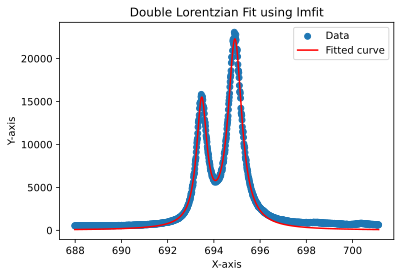

In [19]:
from lmfit import Model
from lmfit.models import LorentzianModel

# Read data from text file
data = np.loadtxt('Exemple_Rubis.asc')

x_data = data[:, 0]
y_data = data[:, 1]

# Create an lmfit Model
model = Model(double_lorentzian)

# Set initial parameter guesses
params = model.make_params(a1=1, x01=693, gamma1=1, a2=1, x02=695, gamma2=1)  # Adjust initial guesses as per your data

# Fit the data to the model
result = model.fit(y_data, params, x=x_data)

# Print fit statistics
print(result.fit_report())

# Plot the original data and the fitted curve
plt.figure(3)
plt.scatter(x_data, y_data, label='Data')
plt.plot(x_data, result.best_fit, color='red', label='Fitted curve')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.title('Double Lorentzian Fit using lmfit')
plt.show()
